In [1]:
from itertools import product, combinations

import numpy as np
from tqdm import tqdm
import uproot
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
file = '/home/xudc/Calorimeter/build/pi0.root'

In [3]:
f = uproot.open(file)

In [4]:
f.keys()

['Energy3D;1', 'XYZ;1', 'Truth;1', 'Energy2D;1', 'XY;1']

In [5]:
energy3d = uproot.open(file + ':' + 'Energy3D')
energy2d = uproot.open(file + ':' + 'Energy2D')
xyz = uproot.open(file + ':' + 'XYZ')
xy = uproot.open(file + ':' + 'XY')
truth = uproot.open(file + ':' + 'Truth')

In [6]:
deposit3d = np.vstack([energy3d[e].array(library='np') for e in tqdm(energy3d.keys())])

100%|██████████| 6700/6700 [01:28<00:00, 76.05it/s] 


In [7]:
deposit2d = np.vstack([energy2d[e].array(library='np') for e in tqdm(energy2d.keys())])

100%|██████████| 100/100 [00:00<00:00, 4268.58it/s]


In [8]:
position3d = np.vstack([xyz[e].array(library='np') for e in tqdm(xyz.keys())])

100%|██████████| 3/3 [00:00<00:00, 2029.50it/s]


In [9]:
position2d = np.vstack([xy[e].array(library='np') for e in tqdm(xy.keys())])

100%|██████████| 2/2 [00:00<00:00, 4130.28it/s]


In [10]:
truthexy = np.vstack([truth[e].array(library='np') for e in tqdm(truth.keys())])

100%|██████████| 6/6 [00:00<00:00, 4903.71it/s]


## 3D scatter

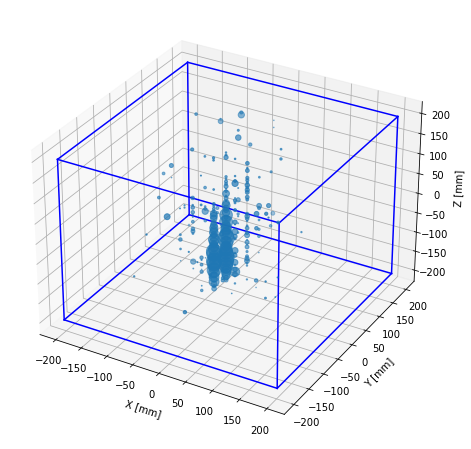

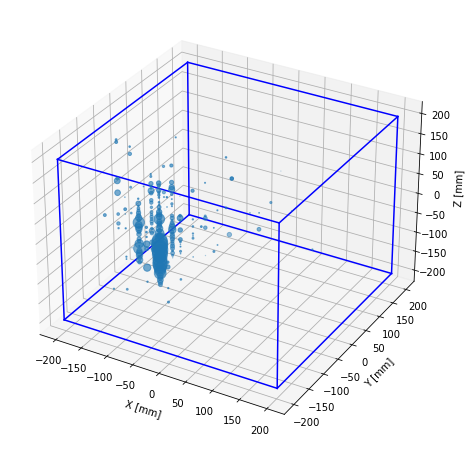

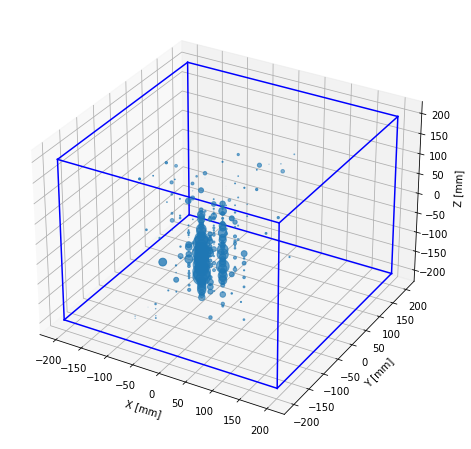

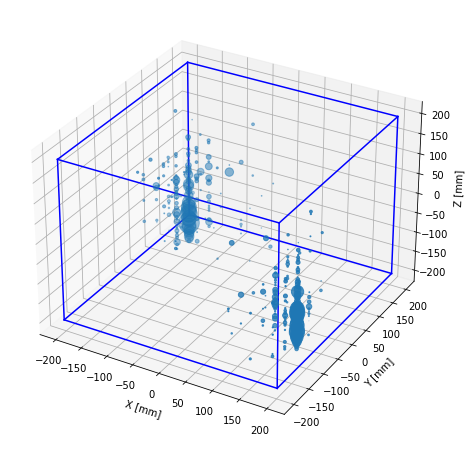

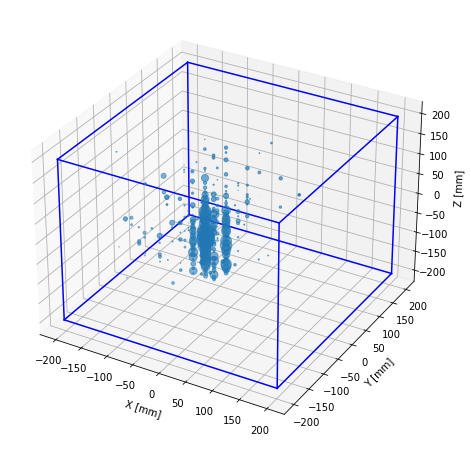

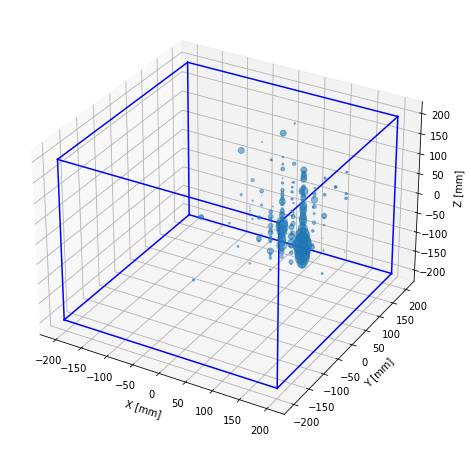

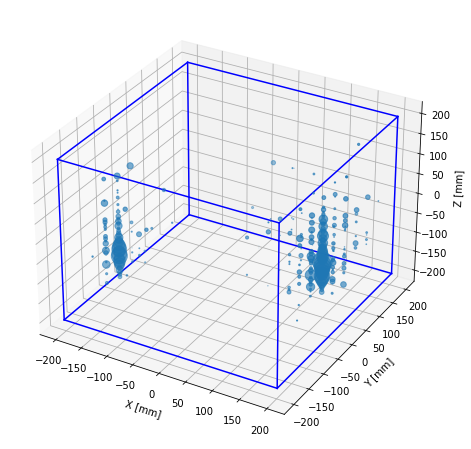

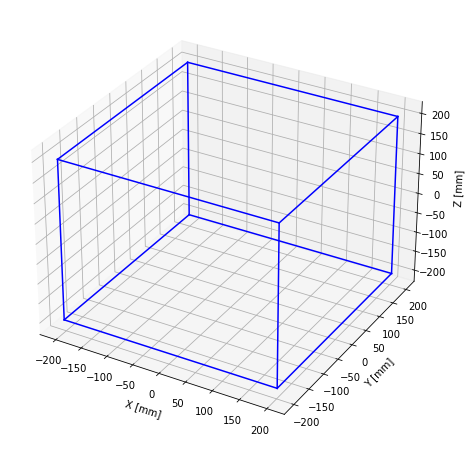

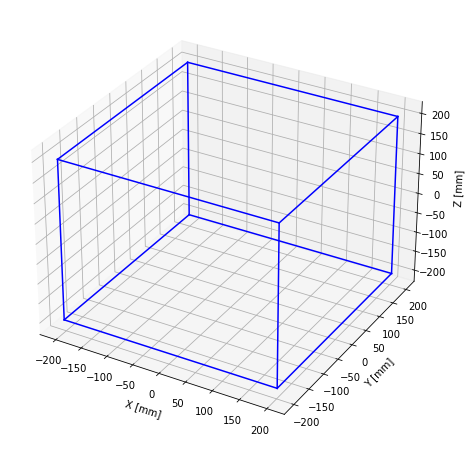

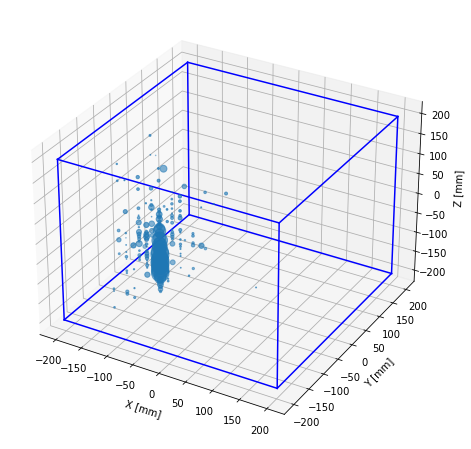

In [11]:
for i in range(10):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca(projection='3d')
    ax.scatter(position3d[0, :], position3d[1, :], position3d[2, :], s=deposit3d[:, i] * 10)
    xl = yl = 40.4 * 10 / 2
    zl = (2 * 66 + 4 * 67) / 2
    for s, e in combinations(np.array(list(product([-xl, xl], [-yl, yl], [-zl, zl]))), 2):
        if ((s - e) == 0).sum() == 2:
            ax.plot3D(*zip(s, e), color='b')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    ax.set_zlabel('Z [mm]')

    plt.show()

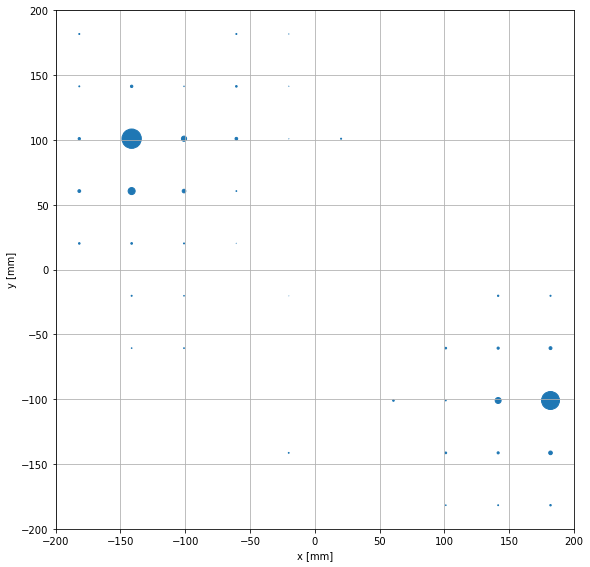

In [12]:
i = 3

fig = plt.figure(figsize=(8, 8))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])
ax.grid()
ax.scatter(position2d[0], position2d[1], s=deposit2d[:, i])
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

plt.show()

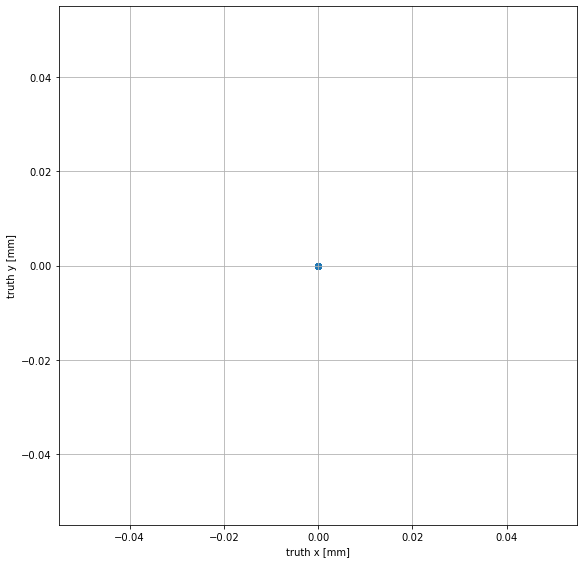

In [13]:
fig = plt.figure(figsize=(8, 8))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])

ax.scatter(truthexy[4], truthexy[5])
ax.grid()
ax.set_xlabel('truth x [mm]')
ax.set_ylabel('truth y [mm]')
plt.show()